- **Generative modeling**: Generate data samples that resemble to the distribution of the training data.
- **Generative Adversarial Networks (GAN)** = generator network + discriminator network <br>
  A clever new way to leverage the power of discriminative models (e.g., classifiers and regressors) to get 
good generative models The data generator is improved until it generates something that resembles the real data..

![input_emb](figure/gan.png)

Both networks are in competition with each other. 
- The generator network attempts to fool the discriminator network.
- The discriminator network adapts to the new fake data.
- This information, in turn is used to improve the generator network, and so on.

### Discriminator

- The discriminator is a **binary classifier** to distinguish if the input x is real (from real data) or fake (from the generator).
- Typically, the discriminator outputs a scalar prediction $o \in \mathbb{R}$ for input $x$, and then applies sigmoid function to obtain the predicted probability
\begin{equation}
\begin{aligned}
    D(x) = 1/(1+e^{-o}).
\end{aligned}
\end{equation}
- Assume the label $y$ for the true data is 1 and <font color='red'>0 for the fake data</font>. We train the discriminator to minimize the cross-entropy loss:
\begin{equation}
\begin{aligned}
    \min_D {-y \log{D(x)} - (1-y)\log{(1-D(x)))}}.
\end{aligned}
\end{equation}

### Generator

- Let $z$ be a **latent variable**. The generator first some parameter $z \in \mathbb{R}^d$ from a source of randomness or noise, e.g., a multivariate normal distribution $z \sim N_d(0,I)$.
- It then applies a function to generate $x^\prime = G(z)$. The **goal** of the generator is to fool the discriminator
to classify $x^\prime = G(z)$ as true data, i.e., we want $D(G(z)) \approx 1$.
- In other words, for a given discriminator $D$, we update the parameters of the generator $G$ to <font color='red'>maximize</font>(fool the discriminator) the cross-entropy loss when  <font color='red'>$y = 0$</font>, i.e.,
\begin{equation}
\begin{aligned}
    \max_G {- (1-y)\log{(1-D(G(z))))}} = \max_G {-\log{(1-D(G(z))))}}.
\end{aligned}
\end{equation}
- Similarly, we <font color='red'>maximize</font> the following loss when <font color='red'>$y=1$</font>:
\begin{equation}
\begin{aligned}
    \max_G {-y \log{D(G(z))}} = \max_G {- \log{D(G(z)))}}.
\end{aligned}
\end{equation}

### The minimax problem

To sum up, $D$ and $G$ are playing a “minimax” game with the comprehensive objective function:
\begin{equation}
\begin{aligned}
    \min_D \max_G {-\mathbb{E}_{x \sim Data}{\log{D(x)}} - \mathbb{E}_{z \sim Noise}{\log{(1 - D(G(z)))}}}.
\end{aligned}
\end{equation}

In [1]:
import matplotlib.pyplot as plt
import torch
from d2l import torch as d2l
from torch import nn

In [2]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)

    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())

    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +
              loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

In [3]:
def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G

In [4]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(num_epochs):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)

            # Visualize generated examples
            Z = torch.normal(0, 1, size=(100, latent_dim))
            fake_X = net_G(Z).detach().numpy()
            animator.axes[1].cla()
            animator.axes[1].scatter(data[:, 0], data[:, 1])
            animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
            animator.axes[1].legend(['real', 'generated'])
            # Show the losses
            loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
            animator.add(epoch + 1, (loss_D, loss_G))
            print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
                  f'{metric[2] / timer.stop():.1f} examples/sec')
    plt.show()

loss_D 0.592, loss_G 0.961, 295.1 examples/sec


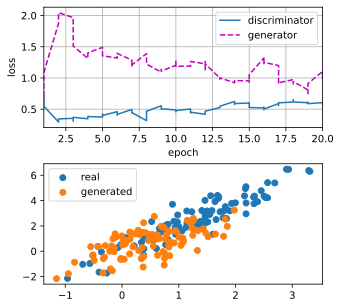

In [8]:
X = torch.normal(0.0, 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b
print(f'The covariance matrix is\n{torch.matmul(A.T, A)}')

batch_size = 64
data_iter = d2l.load_array((data,), batch_size)

# Generator
net_G = nn.Sequential(nn.Linear(2, 2))

# Discriminator
net_D = nn.Sequential(
    nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1))

lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G,
      latent_dim, data[:100].detach().numpy())